In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from pathlib import Path
import random
import matplotlib.pyplot as plt
import gc

import biojepa_ac_v0_5 as model
from bio_dataloader import PretrainLoader, TrainingLoader, AlignmentLoader

## BioJEPA Model load

In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [3]:
torch.cuda.is_available()

False

In [4]:
def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cpu


In [5]:
torch.manual_seed(1337)
random.seed(1337)

## Training Configs

In [6]:
data_dir = Path('/Users/djemec/data/jepa/v0_4')
train_dir = data_dir / 'training'
pretrain_dir = data_dir / 'pretraining'
checkpoint_dir = Path('/Users/djemec/data/jepa/v0_5') / 'checkpoints'
pert_dir = data_dir / 'pert_embd'

**Loading feature banks**

In [7]:
input_bank = torch.from_numpy(np.load(pert_dir / 'input_embeddings_dna.npy')).float().to(DEVICE)
anchor_bank = torch.from_numpy(np.load(pert_dir / 'action_embeddings_esm2.npy')).float().to(DEVICE)
print(f'Banks Loaded. Input(DNA): {input_bank.shape}, Anchor(Prot): {anchor_bank.shape}')


Banks Loaded. Input(DNA): torch.Size([1250, 1536]), Anchor(Prot): torch.Size([1087, 320])


In [8]:
pt_epochs = 10
batch_size = 32

n_genes = 5000
n_layers = 2
n_heads = 2
n_embd = 8
pert_latent_dim = 320
pert_mode_dim = 64

training_file_chunk = 10000
pretraining_file_chunk = 50000



In [9]:
torch.set_float32_matmul_precision('high')
config = model.BioJepaConfig(
    num_genes = n_genes,
    n_layer= n_layers,
    heads= n_heads,
    embed_dim = n_embd,
    n_pre_layer= n_layers,
    pert_latent_dim=pert_latent_dim,
    pert_mode_dim=pert_mode_dim
)
model = model.BioJepa(config).to(DEVICE)

In [10]:
print(f'Student/Teacher: {sum(p.numel() for p in model.student.parameters() if p.requires_grad)}')
print(f'ACpredictor: {sum(p.numel() for p in model.predictor.parameters() if p.requires_grad)}')
print(f'PerturbationComposer: {sum(p.numel() for p in model.composer.parameters() if p.requires_grad)}')

Student/Teacher: 41930
ACpredictor: 45168
PerturbationComposer: 882880


### Pre-Training

In [11]:
pt_train_loader = PretrainLoader(batch_size=batch_size, split='train', data_dir=pretrain_dir, device=DEVICE)
pt_val_loader = PretrainLoader(batch_size=batch_size, split='val', data_dir=pretrain_dir, device=DEVICE)

found 3 shards for split train
loading /Users/djemec/data/jepa/v0_4/pretraining/train/pt_shard_k562e_train_0000.npz
found 1 shards for split val
loading /Users/djemec/data/jepa/v0_4/pretraining/val/pt_shard_k562e_val_0000.npz


In [12]:
pt_train_total = 112373
pt_val_total = 11044
steps_per_epoch = pt_train_total // batch_size
pt_max_steps = pt_epochs * steps_per_epoch
steps_per_epoch, pt_max_steps

(3511, 35110)

In [13]:
pt_LR = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=pt_LR, weight_decay=0.05)

In [14]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=pt_LR, total_steps=pt_max_steps, pct_start=0.05
)

In [15]:
pt_lossi = []
step = 0
total_epoch_loss = 0

In [16]:
model.train()

for step in range(pt_max_steps):
    last_step = (step == pt_max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 100 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 10
            for i in range(val_loss_steps):
                x_val, total_val = pt_val_loader.next_batch()

                val_loss = model.forward_pretrain(x_val, total_val)
                val_loss_accum += val_loss.item()

            avg_val_loss = val_loss_accum / val_loss_steps
            print(f'val loss: {avg_val_loss:.4f}')
            
        # with open(log_file, 'a') as f:
        #    f.write(f'{step} test {test_loss_accum.item():.4f}\n')
        model.train()


    if step > 0 and (step+1) % steps_per_epoch ==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_pt_ckpt_{step}.pt')

    # Pre-Training
    x, total = pt_train_loader.next_batch()
    
    optimizer.zero_grad()
    
    loss = model.forward_pretrain(x, total)
    loss.backward()

    # gradient clipping
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    # Update Teacher (V-JEPA Momentum)
    model.update_teacher()
    
    scheduler.step()
    
    pt_lossi.append(loss.item())
    total_epoch_loss += loss.item()
    
    if step % 25 == 0:
        print(f'Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}')
    
    
    if step > 0 and (step+1) % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f'=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===')
        total_epoch_loss = 0.0
    
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_pt_ckpt_{step}_final.pt')



val loss: 86.4762
Step 0 | Loss: 86.44909 | LR: 4.00e-06
Step 25 | Loss: 86.31913 | LR: 4.05e-06
Step 50 | Loss: 86.06020 | LR: 4.20e-06
Step 75 | Loss: 85.94713 | LR: 4.44e-06
val loss: 85.7466
Step 100 | Loss: 85.71944 | LR: 4.78e-06
Step 125 | Loss: 85.50935 | LR: 5.22e-06
Step 150 | Loss: 85.33066 | LR: 5.74e-06
Step 175 | Loss: 85.04675 | LR: 6.36e-06
val loss: 84.7349
Step 200 | Loss: 84.71017 | LR: 7.08e-06
Step 225 | Loss: 84.38179 | LR: 7.88e-06
Step 250 | Loss: 84.01744 | LR: 8.77e-06
Step 275 | Loss: 83.57784 | LR: 9.74e-06
val loss: 83.1414
Step 300 | Loss: 83.15659 | LR: 1.08e-05
Step 325 | Loss: 82.58609 | LR: 1.19e-05
Step 350 | Loss: 82.01019 | LR: 1.32e-05
Step 375 | Loss: 81.33955 | LR: 1.45e-05
val loss: 80.5015
Step 400 | Loss: 80.49790 | LR: 1.59e-05
Step 425 | Loss: 79.56096 | LR: 1.73e-05
Step 450 | Loss: 78.55892 | LR: 1.88e-05
Step 475 | Loss: 77.25034 | LR: 2.04e-05
val loss: 75.8276
Step 500 | Loss: 75.83745 | LR: 2.21e-05
Step 525 | Loss: 74.11982 | LR: 2.38

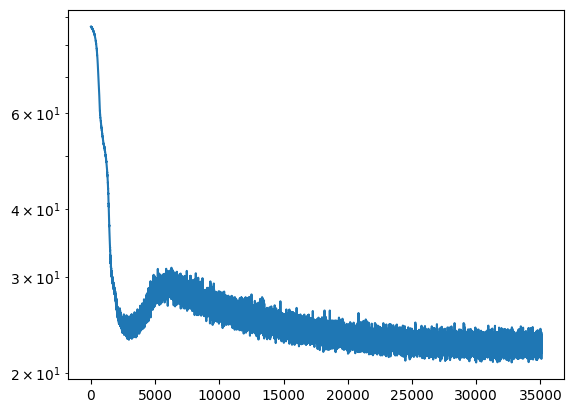

In [17]:
plt.plot(pt_lossi[:])
plt.yscale('log')

In [18]:
del pt_val_loader
del pt_train_loader

gc.collect()
torch.cuda.empty_cache()

## Perturbation Training

In [19]:
# Constants for BioJEPA
modality_to_id = {
    'protein': 0,
    'chemical': 1,
    'dna': 2
}

mode_to_id = {
    'crispri': 0,
    'crispra': 1,
    'overexpression': 2,
    'knockout': 3,
    'inhibitor': 4,
    'agonist': 5,
    'degrader': 6,
    'binder': 7,
    'control': 8,
    'unknown': 9
}

In [20]:
align_total = 1250
align_batch_size = 32
align_epochs = 1000
align_steps_per_epoch = align_total // align_batch_size
align_max_steps = align_epochs * align_steps_per_epoch
align_steps_per_epoch, align_max_steps

(39, 39000)

In [21]:
align_train_loader = AlignmentLoader(align_batch_size, 'train', pert_dir, DEVICE)
align_val_loader = AlignmentLoader(align_batch_size, 'val', pert_dir, DEVICE)

found 1 shards for split train
loading /Users/djemec/data/jepa/v0_4/pert_embd/train/pert_pairs_cripri_train.npz
found 1 shards for split val
loading /Users/djemec/data/jepa/v0_4/pert_embd/val/pert_pairs_cripri_val.npz


In [22]:
align_lr = 4e-3
align_optimizer = torch.optim.AdamW(model.composer.parameters(), lr=align_lr)


In [23]:
align_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    align_optimizer, max_lr=align_lr, total_steps=align_max_steps, pct_start=0.05
)

In [24]:
total_epoch_loss = 0
align_lossi = []

In [25]:
model.train()
for step in range(align_max_steps):
    last_step = (step == align_max_steps - 1)

    if step % 10 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 10
            for i in range(val_loss_steps):
                inp_idx, anc_idx, inp_mod, inp_mode = align_val_loader.next_batch()
                inp_feats = input_bank[inp_idx]
                anc_feats = anchor_bank[anc_idx]

                B = inp_idx.shape[0]
                anc_mod = torch.full((B,), modality_to_id['protein'], device=DEVICE, dtype=torch.long)
                anc_mode = torch.full((B,), mode_to_id['control'], device=DEVICE, dtype=torch.long)

                val_loss = model.forward_alignment(
                    anchor_feats=anc_feats, anchor_mod=anc_mod, anchor_mode=anc_mode,
                    positive_feats=inp_feats, positive_mod=inp_mod, positive_mode=inp_mode
                    )
    
                val_loss_accum += val_loss.item()

            avg_val_loss = val_loss_accum / val_loss_steps
            print(f'val loss: {avg_val_loss:.4f}')
            
        # with open(log_file, 'a') as f:
        #    f.write(f'{step} test {test_loss_accum.item():.4f}\n')
        model.train()


    if step > 0 and (step+1) % steps_per_epoch==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_perturb_ckpt_{step}.pt')

    # Perturb Pretrain

    inp_idx, anc_idx, inp_mod, inp_mode = align_train_loader.next_batch()
    
    # Lookup Features
    inp_feats = input_bank[inp_idx]
    anc_feats = anchor_bank[anc_idx]
    
    # Construct Anchor Metadata
    # Anchors are Proteins (Mod=0) acting as targets (Mode=Control/Identity/8)
    B = inp_idx.shape[0]
    anc_mod = torch.full((B,), modality_to_id['protein'], device=DEVICE, dtype=torch.long)
    anc_mode = torch.full((B,), mode_to_id['control'], device=DEVICE, dtype=torch.long)
    
    # Forward
    align_optimizer.zero_grad()

    loss = model.forward_alignment(
        anchor_feats=anc_feats, anchor_mod=anc_mod, anchor_mode=anc_mode,
        positive_feats=inp_feats, positive_mod=inp_mod, positive_mode=inp_mode
    )
    
    loss.backward()
    align_optimizer.step()
    align_scheduler.step()

    align_lossi.append(loss.item())
    total_epoch_loss += loss.item()
    
    if step % 25 == 0:
        print(f'Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}')

    if step > 0 and (step+1) % align_steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / align_steps_per_epoch
        print(f'=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===')
        total_epoch_loss = 0.0

    if last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_perturb_ckpt_{step}_final.pt')



loading /Users/djemec/data/jepa/v0_4/pert_embd/val/pert_pairs_cripri_val.npz
loading /Users/djemec/data/jepa/v0_4/pert_embd/val/pert_pairs_cripri_val.npz
val loss: 3.4659
Step 0 | Loss: 3.46573 | LR: 4.00e-10
loading /Users/djemec/data/jepa/v0_4/pert_embd/val/pert_pairs_cripri_val.npz
loading /Users/djemec/data/jepa/v0_4/pert_embd/val/pert_pairs_cripri_val.npz
loading /Users/djemec/data/jepa/v0_4/pert_embd/val/pert_pairs_cripri_val.npz
val loss: 3.4661
loading /Users/djemec/data/jepa/v0_4/pert_embd/val/pert_pairs_cripri_val.npz
loading /Users/djemec/data/jepa/v0_4/pert_embd/val/pert_pairs_cripri_val.npz
loading /Users/djemec/data/jepa/v0_4/pert_embd/val/pert_pairs_cripri_val.npz
val loss: 3.4665
Step 25 | Loss: 3.45875 | LR: 4.00e-10
loading /Users/djemec/data/jepa/v0_4/pert_embd/val/pert_pairs_cripri_val.npz
loading /Users/djemec/data/jepa/v0_4/pert_embd/val/pert_pairs_cripri_val.npz
loading /Users/djemec/data/jepa/v0_4/pert_embd/val/pert_pairs_cripri_val.npz
val loss: 3.4669
loading 

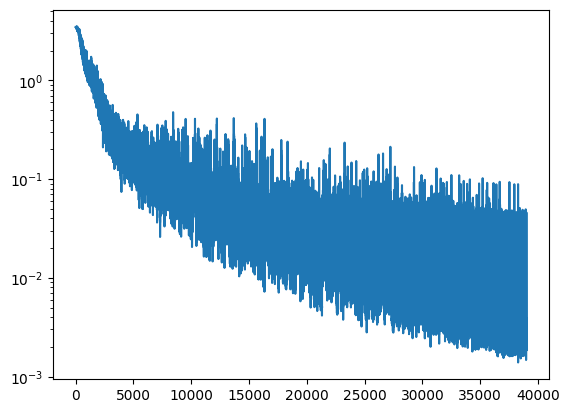

In [26]:
plt.plot(align_lossi[:])
plt.yscale('log')

In [27]:
del align_val_loader
del align_train_loader

gc.collect()
torch.cuda.empty_cache()

## Training

In [28]:
batch_size = 32
LR = 4e-4
pert_LR = LR * 0.1
epochs = 10

In [29]:
train_loader = TrainingLoader(batch_size=batch_size, split='train', data_dir=train_dir, device=DEVICE)
val_loader = TrainingLoader(batch_size=batch_size, split='val', data_dir=train_dir, device=DEVICE)


found 11 shards for split train
loading /Users/djemec/data/jepa/v0_4/training/train/shard_k562e_train_0005.npz
found 2 shards for split val
loading /Users/djemec/data/jepa/v0_4/training/val/shard_k562e_val_0001.npz


In [30]:
steps_per_epoch = 101682 // batch_size
max_steps = epochs * steps_per_epoch
steps_per_epoch, max_steps

(3177, 31770)

In [31]:
optimizer = torch.optim.AdamW([
    {'params': model.predictor.parameters(), 'lr': LR},       
    {'params': model.composer.parameters(),  'lr': pert_LR} 
], weight_decay=0.05)

In [32]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=[LR, pert_LR], total_steps=max_steps, pct_start=0.05
)

In [33]:
lossi = []
total_epoch_loss = 0

In [ ]:
model.freeze_encoders()
model.train()

for step in range(max_steps):

    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 100 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 10
            for i in range(val_loss_steps):
                xc, xct, xt, xtt, p_idx, p_mod, p_mode = val_loader.next_batch()
                p_feats = input_bank[p_idx]


                val_loss = model(xc, xct,xt, xtt,p_feats, p_mod, p_mode)
                val_loss_accum += val_loss.item()

            avg_val_loss = val_loss_accum / val_loss_steps
            print(f'val loss: {avg_val_loss:.4f}')

        # with open(log_file, "a") as f:
        #    f.write(f'{step} test {test_loss_accum.item():.4f}\n')
        model.train()


    if step > 0 and (step+1) % steps_per_epoch ==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_ckpt_{step}.pt')


    # Get Batch (xc=Control, xt=Treated/Case)
    xc, xct, xt, xtt, p_idx, p_mod, p_mode = train_loader.next_batch()

    p_feats = input_bank[p_idx]
    
    optimizer.zero_grad()
    
    loss = model(xc, xct,xt, xtt,p_feats, p_mod, p_mode)
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    
    lossi.append(loss.item())
    total_epoch_loss += loss.item()
    
    if step % 25 == 0:
        print(f"Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    
    if step > 0 and (step+1) % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f"=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===")
        total_epoch_loss = 0
    
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_ckpt_{step}_final.pt')

val loss: 49.2080
Step 0 | Loss: 48.85615 | LR: 1.60e-05
Step 25 | Loss: 44.42792 | LR: 1.63e-05
Step 50 | Loss: 43.49993 | LR: 1.70e-05
Step 75 | Loss: 42.14458 | LR: 1.82e-05
val loss: 40.9703
Step 100 | Loss: 40.75428 | LR: 1.98e-05


In [ ]:
plt.plot(lossi[:])
plt.yscale('log')